# Advanced Tuning With Custom Training and Visualization

In our getting started notebook, [1_tuning_of_builtin_xgboost.ipynb](https://github.com/aws-samples/amazon-sagemaker-amt-visualize/blob/main/1_tuning_of_builtin_xgboost.ipynb) we dipped a toe into the water and performed a single hyperparameter optimization (HPO) job with [Amazon SageMaker Automatic Model Tuning (AMT)](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html). We trained and tuned a XGBoost model provided as a SageMaker built-in Algorithms, meaning we did not need to provide our own training script. In the tuning stage, we ran a single tuning job with the Bayesian search method as our HPO strategy.

In this notebook we will take a wider view and also dive deeper. We will **compare two strategies** and will **provide our own custom training code**. Further we will spend more time on reviewing the results from the AMT job, to **learn about the hyperparameter space and to which values our model is sensitive**.

For our walkthrough we'll pick Random and Bayesian Search as [tuning strategies](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html). We will run two - otherwise identical - tuning jobs with these strategies, then compare the results side-by-side. 

Further, we will see how to use the information we learned about our hyperparameter space from our initial tuning jobs, to then refine this search scope to run another tuning job, leveraging our newly gained knowledge. We will also see, that we can warmstart tuning jobs, to leverage the results already collected in previous tuning jobs for our model. 

## Overview

This notebook is split into the following sections:
- Setup and imports
- Load and prepare dataset
- Train a Random Forest Classifier using a custom script with SageMaker Training
- Tune hyperparameters with SageMaker AMT using Random & Bayesian strategies
- Review results and refine hyperparameter search space
- Warmstarting

## Overview SageMaker **Training**

![Overview SageMaker Training](img/training_script_mode.png)

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

We ran this notebook using Amazon SageMaker with the version you see in the output of the next cell below. If your version is lower and you encounter issues, we recommend uncommenting the code below to upgrade your pip and SageMaker versions. Make sure to restart your kernel after upgrading for the changes to take effect.

In [2]:
import sagemaker

sagemaker.__version__ 

'2.172.0'

In [3]:
#!pip install --upgrade --quiet pip "sagemaker==2.121.0" # upgrade SageMaker to the recommended version

In [4]:
import os
import pandas as pd
import numpy as np
import boto3

In [5]:
# SDK setup
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sm = boto3.client('sagemaker')
boto_sess = boto3.Session(region_name=region)
sm_sess = sagemaker.session.Session(boto_session=boto_sess, sagemaker_client=sm)

In [6]:
# Data layout and locations. 
# To store our data we are using a prefix in the Amazon SageMaker default bucket. Feel free to adjust to your preferences.

BUCKET = sm_sess.default_bucket()
PREFIX = 'amt-visualize-demo'
s3_data_url = f's3://{BUCKET}/{PREFIX}/data'

## Load and Prepare dataset

In [7]:
!mkdir -p data

The focus of this notebook is on Hyperparameter Optimization. Hence the actual task and data only play a supporting role. But to give some brief context, we are optimizing the hyperparameters of a Random Forest model that should classify handwritten digits.

We use the Optical Recognition of Handwritten Digits Data Set via scikit-learn:

_Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science._

In [8]:
from sklearn import datasets

digits         = datasets.load_digits()
digits_df      = pd.DataFrame(digits.data)
digits_df['y'] = digits.target

digit: 4


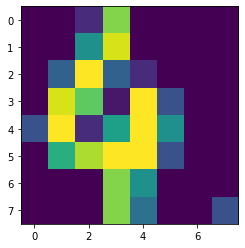

In [9]:
from matplotlib import pyplot as plt

print('digit:', int(digits_df.iloc[100].y))
plt.imshow(digits_df.iloc[100, 1:].values.reshape(8, -1));

In [10]:
digits_df.to_csv('data/digits.csv', index=False)

In [11]:
!aws s3 sync data/ {s3_data_url} --exclude '*' --include 'digits.csv'

upload: data/digits.csv to s3://sagemaker-eu-west-1-811243659808/amt-visualize-demo/data/digits.csv


## Prepare Training

Below we define our training script that we will pass on to SageMaker to run our training. Note that we chose to directly write the required files from our Jupyter Notebook to the `src/` directory using the command `%%writefile`. This is to make this sample more readable and keep all relevant code in one place in this notebook. You can find the source files in the `src/` directory locally in the notebook.


In [12]:
!mkdir -p src
import sys
sys.path.append('src')

### Dependencies and training containers 
When running our training, we often rely on some functions from other libraries and dependecies. In our case, we use functions from the `scikit-learn` and `pandas` libraries.

Luckily, SageMaker offers [several Frameworks](https://sagemaker.readthedocs.io/en/stable/frameworks/index.html) that come pre-installed with popular data science and ML frameworks such Scikit-learn, PyTorch and TensorFlow.

For our purposes in this notebook, we'll be using the [Scikit-learn Framework](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html#prepare-a-scikit-learn-training-script) that has everything we need for our training.

### (Optional) Defining a requirements.txt file
One common practice to collect and organise dependencies and external libraries in Python, is to define a `requirements.txt` file containing a list of imported libraries and their versions.

Although our Scikit-learn container provides us with all the libraries we need, if we needed access to libraries not included in the provided container, we could also define these in `requirements.txt`.

Defining a `requirements.txt` file is an optional step, and not required to launch SageMaker training but it is supported if you wish to include it. SageMaker will automatically use our specified source directory, containing our `train.py` and possibly a `requirements.txt`. For more information, see the [documentation here](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html#using-third-party-libraries).

In [13]:
%%writefile src/requirements.txt

# Not necessary for our training but we may define additional libraries here as required
#[optional-additional-libraries]

Overwriting src/requirements.txt


### Defining our custom training script (train.py)
The training code we are going to use is implemented in Python and mainly contains a method called 'fit'. This method creates a new Random Forest classifier and passes on most of its parameters as hyperparameters before calling the fit method on the classifier. Additionally, some arguments are supported for directly calling the train.py script.

In [14]:
%%writefile src/train.py

#!/usr/bin/env python
import argparse
import os
import traceback
from pathlib import Path

import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import joblib

def fit(train_dir, n_estimators, max_depth, min_samples_leaf, max_features, min_weight_fraction_leaf):
    
    digits = pd.read_csv(Path(train_dir)/'digits.csv')
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(digits.iloc[:, :-1], digits.iloc[:, -1], test_size=.2)
    
    m = RandomForestClassifier(n_estimators=n_estimators, 
                               max_depth=max_depth, 
                               min_samples_leaf=min_samples_leaf,
                               max_features=max_features,
                               min_weight_fraction_leaf=min_weight_fraction_leaf)
    m.fit(Xtrain, ytrain)
    predicted = m.predict(Xtest)
    pre, rec, f1, _ = precision_recall_fscore_support(ytest, predicted, pos_label=1, average='weighted')
    
    print(f'pre: {pre:5.3f} rec: {rec:5.3f} f1: {f1:5.3}')
    
    return m

if __name__ =='__main__':

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.

    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))

    parser.add_argument('--n-estimators', type=int, default=100)
    parser.add_argument('--max-depth', type=int, default=10)
    parser.add_argument('--min-samples-leaf', type=int, default=1)
    parser.add_argument('--max-features', type=str, default='auto')
    parser.add_argument('--min-weight-fraction-leaf', type=float, default=0.01)

    args, _ = parser.parse_known_args()
    trained_model = fit(train_dir=args.train, 
                        n_estimators=args.n_estimators, 
                        max_depth=args.max_depth,
                        min_samples_leaf=args.min_samples_leaf,
                        max_features=args.max_features,
                        min_weight_fraction_leaf=args.min_weight_fraction_leaf)
    
    joblib.dump(trained_model, os.path.join(args.model_dir, 'model.joblib'))   


Overwriting src/train.py


#### Test run our training script locally
Now that we have prepared our training script, let's quickly run it locally to check that it works before you submit it to a container-based training. We run our training script directly from this notebook, which makes it possible to use the Python Debugger and other utilities.

In [15]:
# Running the code from within the notebook. It would then be possible to use the Python Debugger, pdb.
from train import fit
fit('data', 100, 10, 1, 'auto', 0.01)

pre: 0.957 rec: 0.956 f1: 0.956


RandomForestClassifier(max_depth=10, min_weight_fraction_leaf=0.01)

We could also run it directly from the command line. Doing so would trigger the `if __name__ =='__main__':` statement in our script, to parse our command line arguments. That's a great way to test your argument parsing.

When SageMaker loads the container with our script into the training instance, SageMaker will also launch our train.py via the command line.

In [16]:
!cd src && python train.py --train ../data/ --model-dir /tmp/ --n-estimators 100

pre: 0.954 rec: 0.953 f1: 0.952


## Run Training in Containers

With our `train.py` tested, we are ready to create our estimator and call `fit()` to start our training.

### Define our metrics

Recall that in our first notebook, we used a built-in Algorithm for our training. This pre-built container and training script by SageMaker came already configured with its own metrics and metrics defintions. Since we are using a custom training script in this notebook, we now must specify our metrics to SageMaker.

In our `train.py`, we used `print(f'pre: {pre:5.3f} rec: {rec:5.3f} f1: {f1:5.3}')` to emit metrics from our training. During training, this information is printed to `std.out`, which is parsed by SageMaker and sent to Amazon CloudWatch.

In order for SageMaker to successfully parse our metrics, we must provide the Regular Expressions (REGEX), that instruct SageMaker how to extract the numerical values from our print statement above, as described [in the documentation here](https://docs.aws.amazon.com/sagemaker/latest/dg/training-metrics.html). We do this with our `metric_definitions` object below, which we then pass as a parameter to our estimator. 

Note: The metrics we chose here will eventually be used by SageMaker AMT for our HPO jobs, more [information on tuning metrics can be found here](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-define-metrics-variables.html)

In [17]:
metric_definitions = [{'Name': 'valid-precision',  'Regex': r'pre:\s+(-?[0-9\.]+)'},
                      {'Name': 'valid-recall',     'Regex': r'rec:\s+(-?[0-9\.]+)'},
                      {'Name': 'valid-f1',         'Regex': r'f1:\s+(-?[0-9\.]+)'}]                            

In the following cells, we define our estimator, in which we pass our training script, indicate our source directory and specify our training instance configuration with the `instance_type` and `instance_count` variables.

Notice that, we are using an SKLearn estimator, which instructs SageMaker to load our training script onto a container that comes with Scikit-learn and other dependencies pre-installed. The `framework_version` parameter in the estimator defines which Scikit-learn version we wish to run. You  can read more about the parameters [here](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html)

This differs from the estimator used in our [1_tuning_of_builtin_xgboost.ipynb](https://github.com/aws-samples/amazon-sagemaker-amt-visualize/blob/main/1_tuning_of_builtin_xgboost.ipynb) notebook, which we used to run built-in algorithms rather than custom training scripts.

In [18]:
from sagemaker.sklearn.estimator import SKLearn
from sagemaker import get_execution_role

In [19]:
estimator = SKLearn(
    'train.py',
    source_dir='src',
    role=get_execution_role(),
    instance_type= 'ml.m5.large',
    instance_count=1,
    framework_version='0.23-1',
    metric_definitions=metric_definitions,

    # Uncomment the following three lines to use Managed Spot Training
    # use_spot_instances= True,
    # max_run=  60 * 60 * 24,
    # max_wait= 60 * 60 * 24,

    hyperparameters = {'n-estimators': 100,
                       'max-depth': 10,
                       'min-samples-leaf': 1,
                       'max-features': 'auto',
                       'min-weight-fraction-leaf': 0.1}
)

Now let's run the estimator's fit function to train the model using the full training set. This will take a few minutes.

In [20]:
print(s3_data_url)
estimator.fit({'train': s3_data_url}, wait=True)

s3://sagemaker-eu-west-1-811243659808/amt-visualize-demo/data
Using provided s3_resource


INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2023-07-14-12-00-23-550


2023-07-14 12:00:25 Starting - Starting the training job......
2023-07-14 12:01:14 Starting - Preparing the instances for training......
2023-07-14 12:02:07 Downloading - Downloading input data...
2023-07-14 12:02:47 Training - Downloading the training image...
2023-07-14 12:03:23 Training - Training image download completed. Training in progress..2023-07-14 12:03:27,935 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-07-14 12:03:27,939 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-14 12:03:27,978 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-07-14 12:03:28,147 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
2023-07-14 12:03:29,132 sagemaker-training-toolkit INFO  

---

## Overview SageMaker Automatic Model Tuning

Now we can explore more possible `hyperparameters` for the same `estimator` as we have used above. As shown on the diagram, we setup the `HyperparameterTuner` using our custom training script and launch HPO Job. This will initiate Training Jobs wth different hyperparameters from `hpt_ranges`. 

![Overview SageMaker Automatic Model Tuning](img/amt_script_mode.png)

### What is necessary to define for [`HyperparameterTuner`](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html)?

#### 1. Scoping of hyperparameter values

The hyperparameters are different from algorithm to algorithm. In our example we use scikit-learn implementation of Random Forest, so you can look into all its hyperparameters [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

The search space for the hyperparameters is defined by using the following types of hyperparameters:

- **Categorical parameters**, where the values are enumerable
- **Continuous parameters** with any real number values between the pre-defined minimal and maximal values
- **Integer parameters** with any integer value between the minimum and maximum values

Additional information on hyperparameters structure and the step between them (scaling) can be found [here](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-define-ranges.html).

#### 2. The objective metric for the Tuning Job to optimize 

The metric is necessary for custom training code, a built-in SageMaker algorithm can use default values. You can check out [Define Metrics documentation page](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-define-ranges.html) to see the examples of metric definitions.  


#### 3. The optimization strategy

How will the HPO job choose concrete hyperparameters? There are four strategies currently available that you can use for SageMaker AMT:

- Grid Search
- Random Search 
- Bayesian Optimization (default)
- Hyperband.

An explanation for each of the strategies can be found [here](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html). For demonstration purposes, let's compare Random Search and Bayesian Optimization in the following steps.

## Automatic Model Tuning Jobs - Random Search

We need to define the maximum number of trials (`max_jobs`) and the number of trials to be evaluated in parallel (`max_parallel_jobs`). 

For the purposes of our visualizations later on in the notebook, we stick to a value of `2` for `max_parallel_jobs`, across all strategies to make it easier to compare them "by eye" in our visualizations futher down in the notebook. 

In [21]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner

n = 50
k = 2

hpt_ranges = {'n-estimators': IntegerParameter(1, 200),
              'max-depth': IntegerParameter(1, 20), 
              'min-samples-leaf': IntegerParameter(1, 10),
              'min-weight-fraction-leaf': ContinuousParameter(0.01, 0.5),
              'max-features': CategoricalParameter(['auto', 'log2', 'sqrt'])}

tuner_parameters = {'estimator': estimator,
                    'base_tuning_job_name': 'random',
                    'metric_definitions': metric_definitions,
                    
                    'objective_metric_name': 'valid-f1',
                    'objective_type': 'Maximize',
                    'hyperparameter_ranges': hpt_ranges,
                    'strategy': 'Random',
                    
                    'max_jobs': n,
                    'max_parallel_jobs': k} # With 'Random' we could use a much higher parallelization here, 
                                            # as all trials/jobs are independent

In [22]:
random_tuner = HyperparameterTuner(**tuner_parameters)
random_tuner.fit({'train': s3_data_url}, wait=False)
random_tuner_name = random_tuner.describe()['HyperParameterTuningJobName']
print(f'tuning job submitted: {random_tuner_name}.')

Using provided s3_resource


INFO:sagemaker:Creating hyperparameter tuning job with name: random-230714-1404


tuning job submitted: random-230714-1404.


## Automatic Model Tuning Jobs - Bayesian Optimization

Bayesian Optimization treats optimization as a regression problem and takes into account the past evaluation outcomes of each run to sample new candidates that are more likely to optimize the objective metric, thus, trying to arrive at optimised set of hyperparameters as soon as possible.

In [23]:
tuner_parameters['strategy']             = 'Bayesian'
tuner_parameters['base_tuning_job_name'] = 'bayesian'

In [24]:
bayesian_tuner = HyperparameterTuner(**tuner_parameters)
bayesian_tuner.fit({'train': s3_data_url}, wait=False)
bayesian_tuner_name = bayesian_tuner.describe()['HyperParameterTuningJobName']
print(f'tuning job submitted: {bayesian_tuner_name}.')

Using provided s3_resource


INFO:sagemaker:Creating hyperparameter tuning job with name: bayesian-230714-1404


tuning job submitted: bayesian-230714-1404.


The tuning jobs are now running in the background and can take up to 30 minutes, depending on the selected instance types. Executing the code in the next cell will help you to determine when the tuning jobs are finished (indicated by `!`).

In [25]:
random_tuner.wait()
bayesian_tuner.wait()

.............................................................................................................................................................................................................................................................................................................!
........................................................!


## Review Results
To visualize the results of the tuning jobs, we use a custom visualization package which is provided in the folder `amtviz`.

For now, we visualize the results for each strategy (Random and Bayesian), separately. Which kind of strategy will perform better? Let's see.

In [26]:
!pip install -Uq pip altair

In [27]:
from amtviz import visualize_tuning_job

Setting altair renderer to png.


### Random

First, we generate the visualization for the random tuner job.

Tuning job random-230714-1404        status: Completed

Number of training jobs with valid objective: 50
Lowest: 0.05079999938607216 Highest 0.9049999713897705


,max-depth,max-features,min-samples-leaf,min-weight-fraction-leaf,n-estimators,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,valid-f1
45,6.0,sqrt,6.0,0.010125,12.0,random-230714-1404-005-dbecb7c1,Completed,2023-07-14 14:08:24+02:00,2023-07-14 14:09:06+02:00,42.0,random-230714-1404,0.905
14,12.0,log2,2.0,0.100124,56.0,random-230714-1404-036-f743479b,Completed,2023-07-14 14:23:05+02:00,2023-07-14 14:23:52+02:00,47.0,random-230714-1404,0.905
23,8.0,auto,7.0,0.052894,192.0,random-230714-1404-027-107fbc69,Completed,2023-07-14 14:18:52+02:00,2023-07-14 14:19:39+02:00,47.0,random-230714-1404,0.902
6,8.0,sqrt,4.0,0.046307,18.0,random-230714-1404-044-3808db03,Completed,2023-07-14 14:26:46+02:00,2023-07-14 14:27:33+02:00,47.0,random-230714-1404,0.885
30,13.0,log2,2.0,0.033553,8.0,random-230714-1404-020-cf4ed107,Completed,2023-07-14 14:15:48+02:00,2023-07-14 14:16:35+02:00,47.0,random-230714-1404,0.873
8,15.0,auto,10.0,0.157100,104.0,random-230714-1404-042-5c60aa51,Completed,2023-07-14 14:25:51+02:00,2023-07-14 14:26:38+02:00,47.0,random-230714-1404,0.849
35,19.0,sqrt,3.0,0.142625,157.0,random-230714-1404-015-9b541325,Completed,2023-07-14 14:13:55+02:00,2023-07-14 14:14:42+02:00,47.0,random-230714-1404,0.840
18,3.0,auto,4.0,0.040534,17.0,random-230714-1404-032-e6701e44,Completed,2023-07-14 14:21:21+02:00,2023-07-14 14:22:03+02:00,42.0,random-230714-1404,0.840
11,17.0,sqrt,7.0,0.061751,11.0,random-230714-1404-039-e6fdd09c,Completed,2023-07-14 14:24:35+02:00,2023-07-14 14:25:22+02:00,47.0,random-230714-1404,0.816
2,7.0,sqrt,4.0,0.221017,95.0,random-230714-1404-048-2e200877,Completed,2023-07-14 14:28:33+02:00,2023-07-14 14:29:19+02:00,46.0,random-230714-1404,0.812


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.


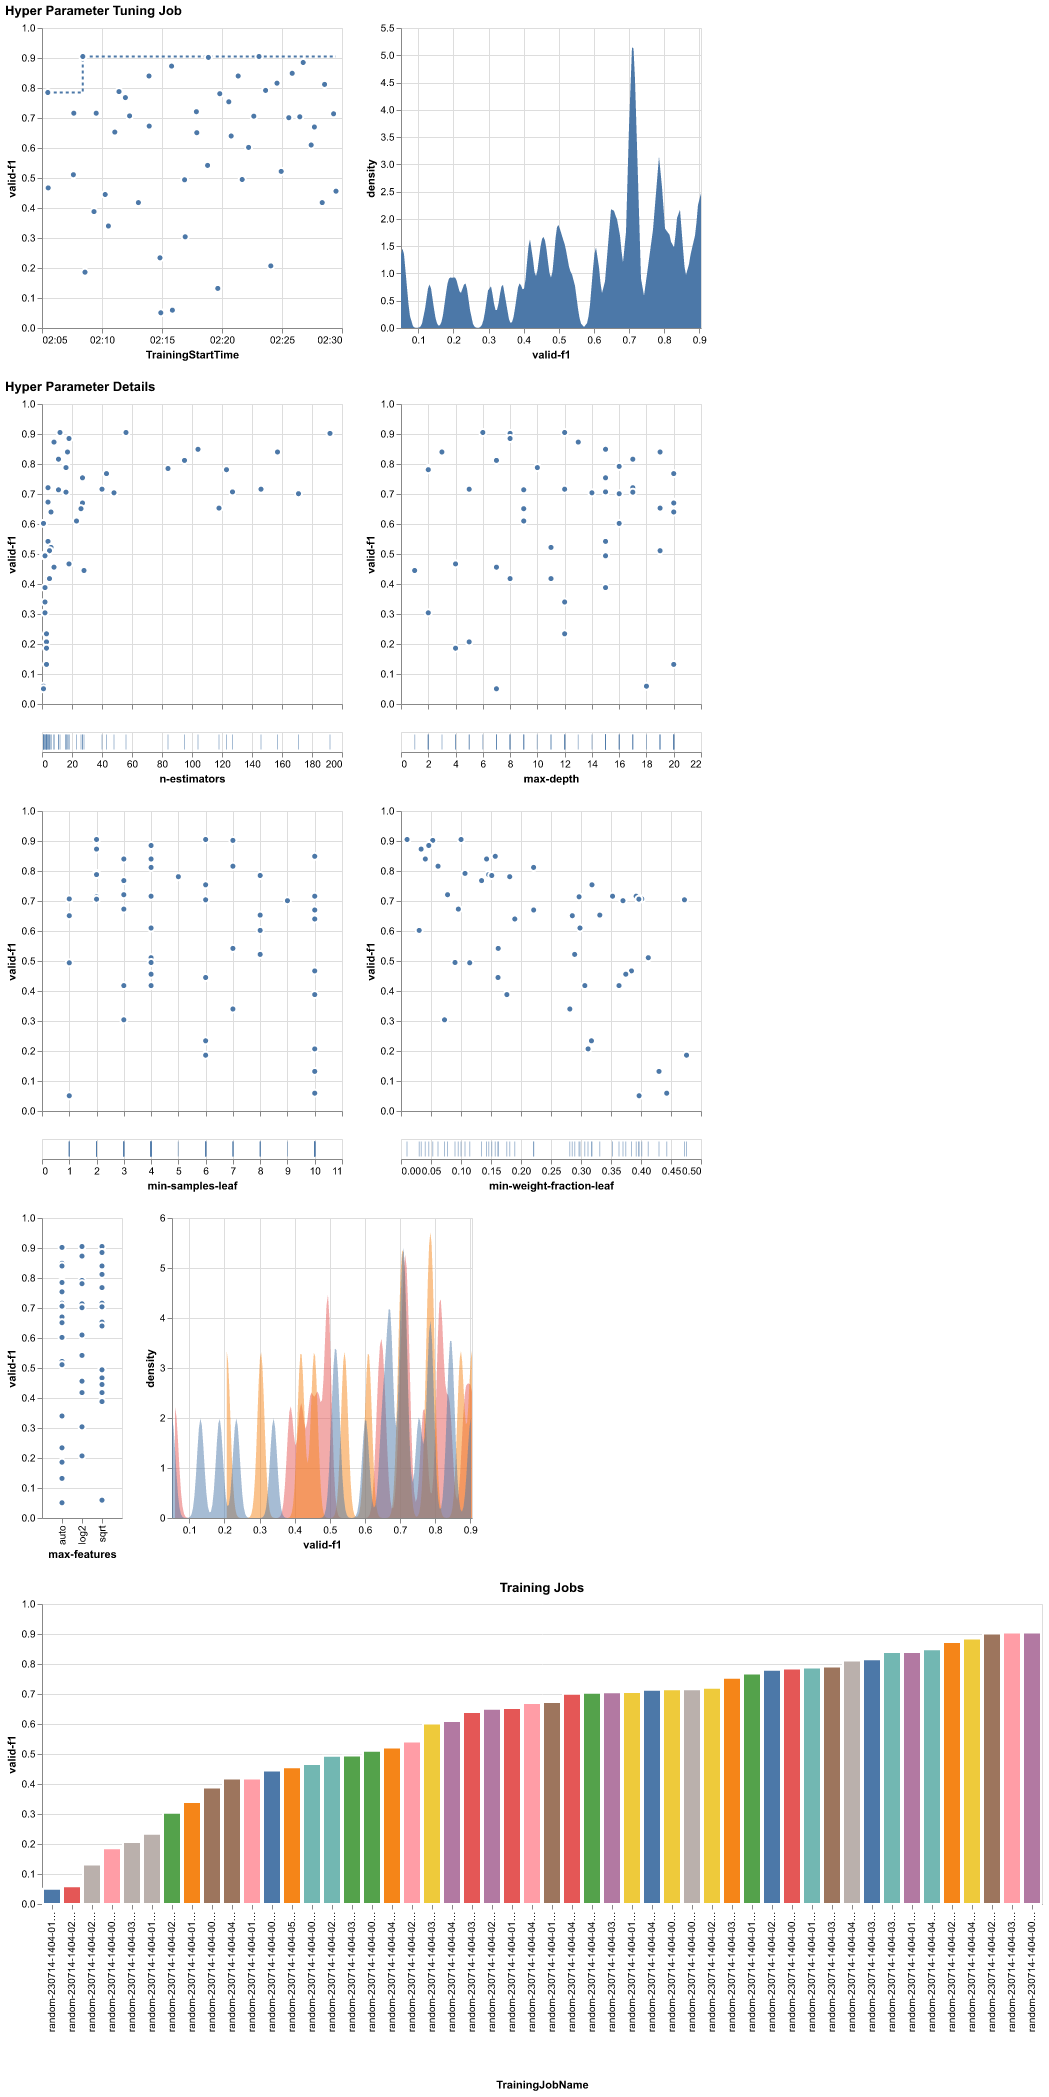

In [28]:
visualize_tuning_job(random_tuner, advanced=True, trials_only=True)

Please note, the generated diagrams can be used interactively. Click inside the scatter plots and drag across the x-axis to focus your view.

### Bayesian

Now, we will have a look at the results for the Bayesian tuner.

Tuning job bayesian-230714-1404      status: Completed

Number of training jobs with valid objective: 50
Lowest: 0.01119999960064888 Highest 0.972000002861023


,max-depth,max-features,min-samples-leaf,min-weight-fraction-leaf,n-estimators,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,valid-f1
20,15.0,log2,1.0,0.010000,200.0,bayesian-230714-1404-030-da1efda5,Completed,2023-07-14 14:22:40+02:00,2023-07-14 14:23:26+02:00,46.0,bayesian-230714-1404,0.972
18,15.0,sqrt,1.0,0.010000,102.0,bayesian-230714-1404-032-b17d611e,Completed,2023-07-14 14:23:41+02:00,2023-07-14 14:24:28+02:00,47.0,bayesian-230714-1404,0.967
25,20.0,auto,2.0,0.010000,37.0,bayesian-230714-1404-025-1b3f97f4,Completed,2023-07-14 14:19:38+02:00,2023-07-14 14:20:20+02:00,42.0,bayesian-230714-1404,0.961
5,13.0,auto,1.0,0.010000,124.0,bayesian-230714-1404-045-ed1f94fa,Completed,2023-07-14 14:30:29+02:00,2023-07-14 14:31:11+02:00,42.0,bayesian-230714-1404,0.961
27,20.0,log2,1.0,0.010000,98.0,bayesian-230714-1404-023-d8fe2d2a,Completed,2023-07-14 14:18:36+02:00,2023-07-14 14:19:18+02:00,42.0,bayesian-230714-1404,0.961
0,14.0,log2,3.0,0.010445,131.0,bayesian-230714-1404-050-fa10f5a3,Completed,2023-07-14 14:33:39+02:00,2023-07-14 14:35:08+02:00,89.0,bayesian-230714-1404,0.959
16,14.0,log2,1.0,0.010000,147.0,bayesian-230714-1404-034-d1642a71,Completed,2023-07-14 14:24:43+02:00,2023-07-14 14:25:25+02:00,42.0,bayesian-230714-1404,0.958
10,13.0,log2,1.0,0.010000,200.0,bayesian-230714-1404-040-81fc1f20,Completed,2023-07-14 14:27:50+02:00,2023-07-14 14:28:31+02:00,41.0,bayesian-230714-1404,0.958
11,14.0,auto,1.0,0.010000,85.0,bayesian-230714-1404-039-5ebfabd3,Completed,2023-07-14 14:27:03+02:00,2023-07-14 14:27:45+02:00,42.0,bayesian-230714-1404,0.958
19,12.0,sqrt,1.0,0.010000,200.0,bayesian-230714-1404-031-bfd45794,Completed,2023-07-14 14:22:50+02:00,2023-07-14 14:23:37+02:00,47.0,bayesian-230714-1404,0.958


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.


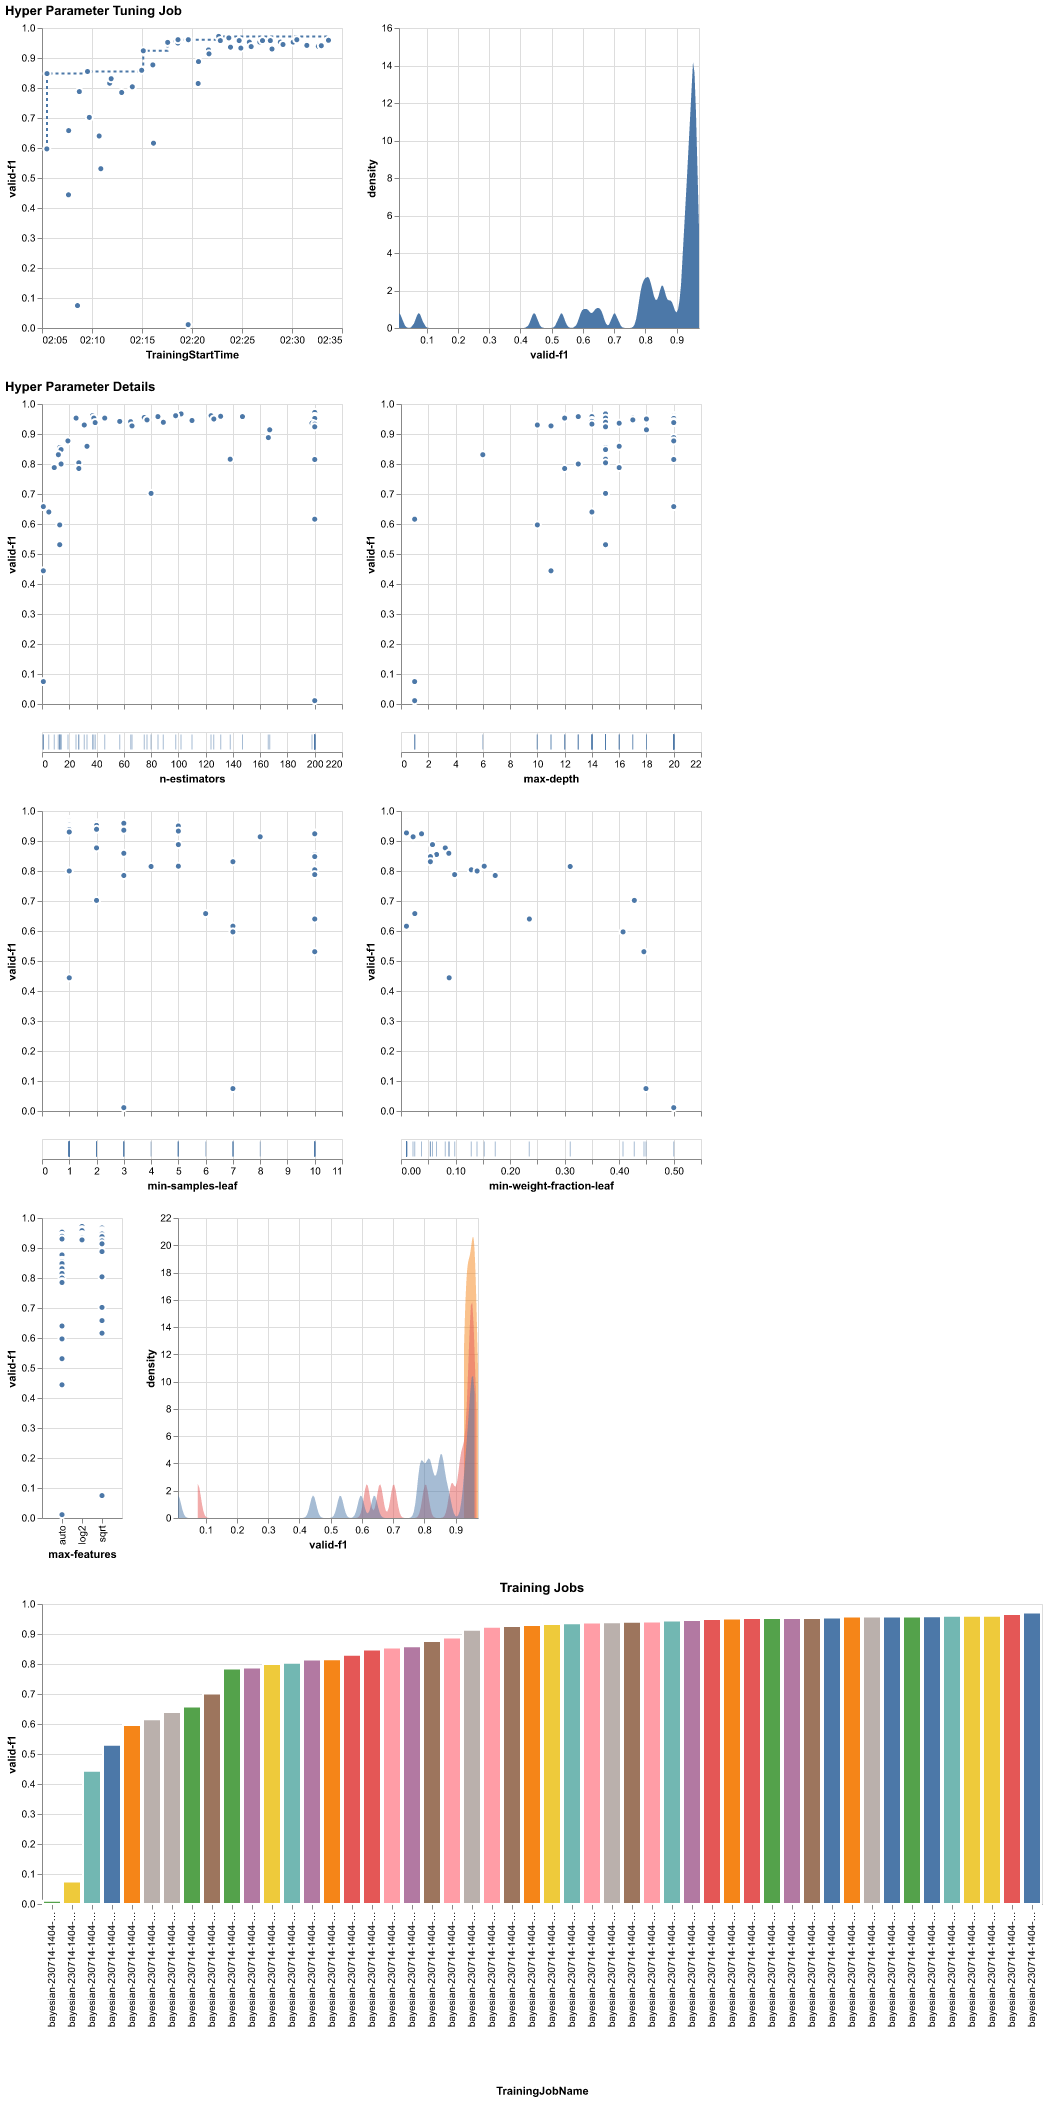

In [29]:
visualize_tuning_job(bayesian_tuner, advanced=True, trials_only=True)

### Both

To make the comparison even easier, we can now view our two HPO jobs side-by-side.

Observe that the trials of both jobs ran over the same time period, thus we can visually compare their progress over time. The dashed colored line shows the cumulative objective metric achieved over time. Comparing the two tuning jobs' lines, we can see that with Bayesian optimization we (usually) reach a better overall result, but also reach it a bit earlier than with a Random Search. Although, given how simple a Random Search is, its performance is quite notable. 

Earlier we mentioned that we kept `max_parallel_jobs=2`, restricting our parallel jobs to 2, for both strategies. If we had increased this value to for example 10 for Random search, we would see the Random search trials are completed much earlier than the trials from the Bayesian tuning job, so it would not be so easy to compare their relative progress just "by eye". 

Tuning job bayesian-230714-1404      status: Completed
Tuning job random-230714-1404        status: Completed

Number of training jobs with valid objective: 100
Lowest: 0.01119999960064888 Highest 0.972000002861023


,max-depth,max-features,min-samples-leaf,min-weight-fraction-leaf,n-estimators,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,valid-f1
20,15.0,log2,1.0,0.010000,200.0,bayesian-230714-1404-030-da1efda5,Completed,2023-07-14 14:22:40+02:00,2023-07-14 14:23:26+02:00,46.0,bayesian-230714-1404,0.972
18,15.0,sqrt,1.0,0.010000,102.0,bayesian-230714-1404-032-b17d611e,Completed,2023-07-14 14:23:41+02:00,2023-07-14 14:24:28+02:00,47.0,bayesian-230714-1404,0.967
27,20.0,log2,1.0,0.010000,98.0,bayesian-230714-1404-023-d8fe2d2a,Completed,2023-07-14 14:18:36+02:00,2023-07-14 14:19:18+02:00,42.0,bayesian-230714-1404,0.961
25,20.0,auto,2.0,0.010000,37.0,bayesian-230714-1404-025-1b3f97f4,Completed,2023-07-14 14:19:38+02:00,2023-07-14 14:20:20+02:00,42.0,bayesian-230714-1404,0.961
5,13.0,auto,1.0,0.010000,124.0,bayesian-230714-1404-045-ed1f94fa,Completed,2023-07-14 14:30:29+02:00,2023-07-14 14:31:11+02:00,42.0,bayesian-230714-1404,0.961
0,14.0,log2,3.0,0.010445,131.0,bayesian-230714-1404-050-fa10f5a3,Completed,2023-07-14 14:33:39+02:00,2023-07-14 14:35:08+02:00,89.0,bayesian-230714-1404,0.959
19,12.0,sqrt,1.0,0.010000,200.0,bayesian-230714-1404-031-bfd45794,Completed,2023-07-14 14:22:50+02:00,2023-07-14 14:23:37+02:00,47.0,bayesian-230714-1404,0.958
10,13.0,log2,1.0,0.010000,200.0,bayesian-230714-1404-040-81fc1f20,Completed,2023-07-14 14:27:50+02:00,2023-07-14 14:28:31+02:00,41.0,bayesian-230714-1404,0.958
11,14.0,auto,1.0,0.010000,85.0,bayesian-230714-1404-039-5ebfabd3,Completed,2023-07-14 14:27:03+02:00,2023-07-14 14:27:45+02:00,42.0,bayesian-230714-1404,0.958
16,14.0,log2,1.0,0.010000,147.0,bayesian-230714-1404-034-d1642a71,Completed,2023-07-14 14:24:43+02:00,2023-07-14 14:25:25+02:00,42.0,bayesian-230714-1404,0.958


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with p

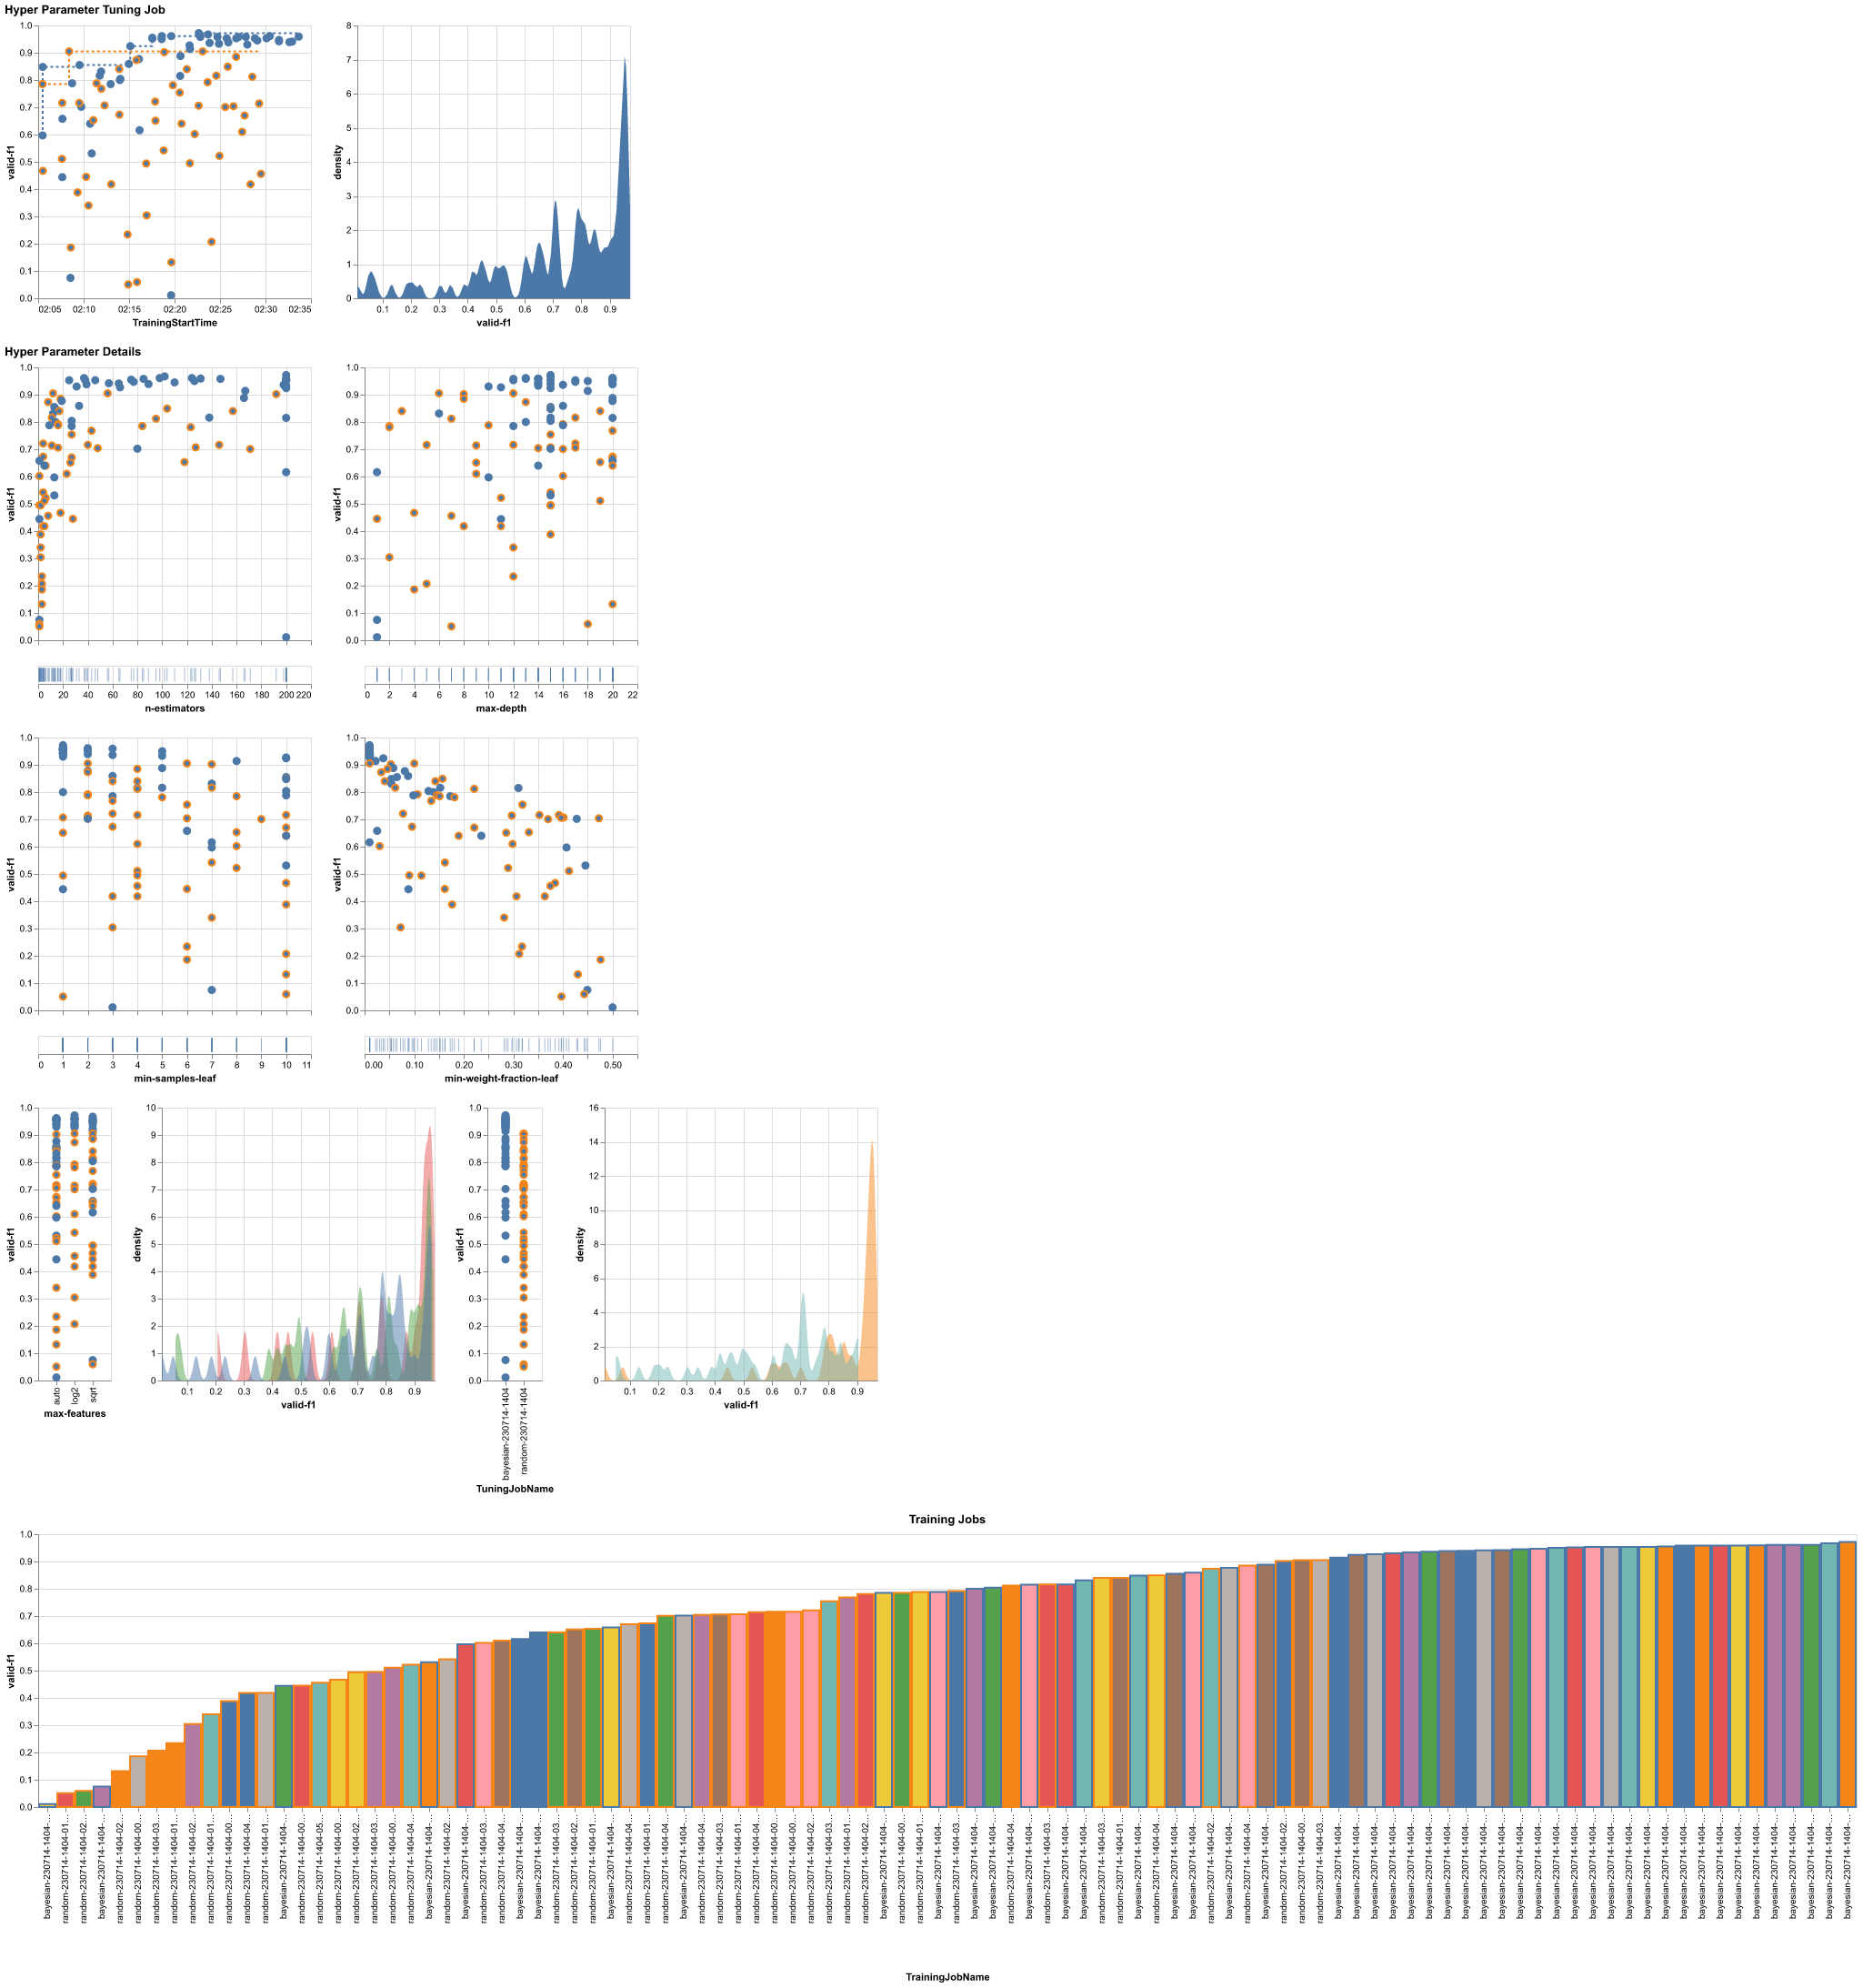

In [30]:
visualize_tuning_job([random_tuner, bayesian_tuner], advanced=True, trials_only=True)

## Warmstart HPO Job

Let's now use our better understanding of good hyperparameter value ranges to do more searching. We do not start from scratch, but [warmstart](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_HyperParameterTuningJobWarmStartConfig.html) a new HPO Job, that incorporates what was learned during the previous HPO run. Thus, we can continue optimizing our model from the point where the previous tuning experiment has finished.

More information on Warm Start HPO Job Types and restrictions can be found [here](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-warm-start.html).

We can compare our range definitions side-by-side to see in what direction we should point our Warmstarted HPO Job. Check the comments below!

In [31]:
from sagemaker.tuner import WarmStartConfig, WarmStartTypes

warm_start_config = WarmStartConfig(warm_start_type=WarmStartTypes.IDENTICAL_DATA_AND_ALGORITHM, 
                                    parents=[bayesian_tuner_name, random_tuner_name]) # Recognize how we point to the previous tuning jobs (both Bayesian and Random)
tuner_parameters['warm_start_config'] =  warm_start_config

# repeated from above, then adjusted based on the runs from above. This is just an illustration, YMMV.
hpt_ranges = {'n-estimators': IntegerParameter(100, 300), # was (1,200). Many of the good values fell onto 200, maybe more is better?
              'max-depth': IntegerParameter(6, 24), # was (1, 20). Many of the good values fell on 20. Maybe more is better?
              'min-samples-leaf': IntegerParameter(1, 6), # was (1, 10) But there were not additional gains above 6.
              'min-weight-fraction-leaf': ContinuousParameter(0.001, 0.15), # was (0.01, 0.5)
              'max-features': CategoricalParameter(['auto', 'log2', 'sqrt'])} # unchanged. Inconclusive with the wide value ranges we searched. 
                                                                              # So let's try again with the narrower search from above.
tuner_parameters['hyperparameter_ranges'] = hpt_ranges
tuner_parameters['base_tuning_job_name'] = 'bayesian-warm'
tuner_parameters['max_jobs'] = n//2 # we can reduce the number of trials, as we already build on what we learned already
tuner_parameters['max_parallel_jobs'] = 1

warmstarted_tuner = HyperparameterTuner(**tuner_parameters)
warmstarted_tuner.fit({'train': s3_data_url}, wait=False)
warmstarted_tuner_name = warmstarted_tuner.describe()['HyperParameterTuningJobName']
print(f'tuning job submitted: {warmstarted_tuner_name}.')

Using provided s3_resource


INFO:sagemaker:Creating hyperparameter tuning job with name: bayesian-warm-230714-1435


tuning job submitted: bayesian-warm-230714-1435.


Visit the SageMaker Hyperparameter tuning jobs view in the AWS console to monitor the progress, or simply use the wait() function as we did before.

In [32]:
warmstarted_tuner.wait()

....................................................................................................................................................................................................................................................................................................................................................!


Setting altair renderer to png.
Tuning job bayesian-warm-230714-1435's parents: random-230714-1404, bayesian-230714-1404
Tuning job bayesian-230714-1404      status: Completed
Tuning job random-230714-1404        status: Completed
Tuning job bayesian-warm-230714-1435 status: Completed

Number of training jobs with valid objective: 125
Lowest: 0.01119999960064888 Highest 0.9860000014305115


,max-depth,max-features,min-samples-leaf,min-weight-fraction-leaf,n-estimators,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,valid-f1
14,24.0,log2,1.0,0.00187,289.0,bayesian-warm-230714-1435-011-b84fd4af,Completed,2023-07-14 14:48:43+02:00,2023-07-14 14:49:30+02:00,47.0,bayesian-warm-230714-1435,0.986
4,24.0,sqrt,1.0,0.00100,112.0,bayesian-warm-230714-1435-021-9d2bde17,Completed,2023-07-14 14:59:47+02:00,2023-07-14 15:00:34+02:00,47.0,bayesian-warm-230714-1435,0.983
11,9.0,sqrt,3.0,0.00100,127.0,bayesian-warm-230714-1435-014-afec7a09,Completed,2023-07-14 14:52:03+02:00,2023-07-14 14:52:44+02:00,41.0,bayesian-warm-230714-1435,0.981
20,15.0,log2,1.0,0.01000,200.0,bayesian-230714-1404-030-da1efda5,Completed,2023-07-14 14:22:40+02:00,2023-07-14 14:23:26+02:00,46.0,bayesian-230714-1404,0.972
1,8.0,log2,1.0,0.00100,172.0,bayesian-warm-230714-1435-024-bdbf7077,Completed,2023-07-14 15:03:08+02:00,2023-07-14 15:03:49+02:00,41.0,bayesian-warm-230714-1435,0.972
2,24.0,sqrt,1.0,0.00100,159.0,bayesian-warm-230714-1435-023-78a85ed9,Completed,2023-07-14 15:02:00+02:00,2023-07-14 15:02:47+02:00,47.0,bayesian-warm-230714-1435,0.972
10,9.0,log2,1.0,0.00100,296.0,bayesian-warm-230714-1435-015-6825bd76,Completed,2023-07-14 14:53:09+02:00,2023-07-14 14:53:51+02:00,42.0,bayesian-warm-230714-1435,0.972
7,21.0,log2,4.0,0.00100,251.0,bayesian-warm-230714-1435-018-e4ea571e,Completed,2023-07-14 14:56:31+02:00,2023-07-14 14:57:12+02:00,41.0,bayesian-warm-230714-1435,0.972
6,24.0,log2,1.0,0.00100,141.0,bayesian-warm-230714-1435-019-6321b2c5,Completed,2023-07-14 14:57:35+02:00,2023-07-14 14:58:17+02:00,42.0,bayesian-warm-230714-1435,0.967
18,15.0,sqrt,1.0,0.01000,102.0,bayesian-230714-1404-032-b17d611e,Completed,2023-07-14 14:23:41+02:00,2023-07-14 14:24:28+02:00,47.0,bayesian-230714-1404,0.967


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with p

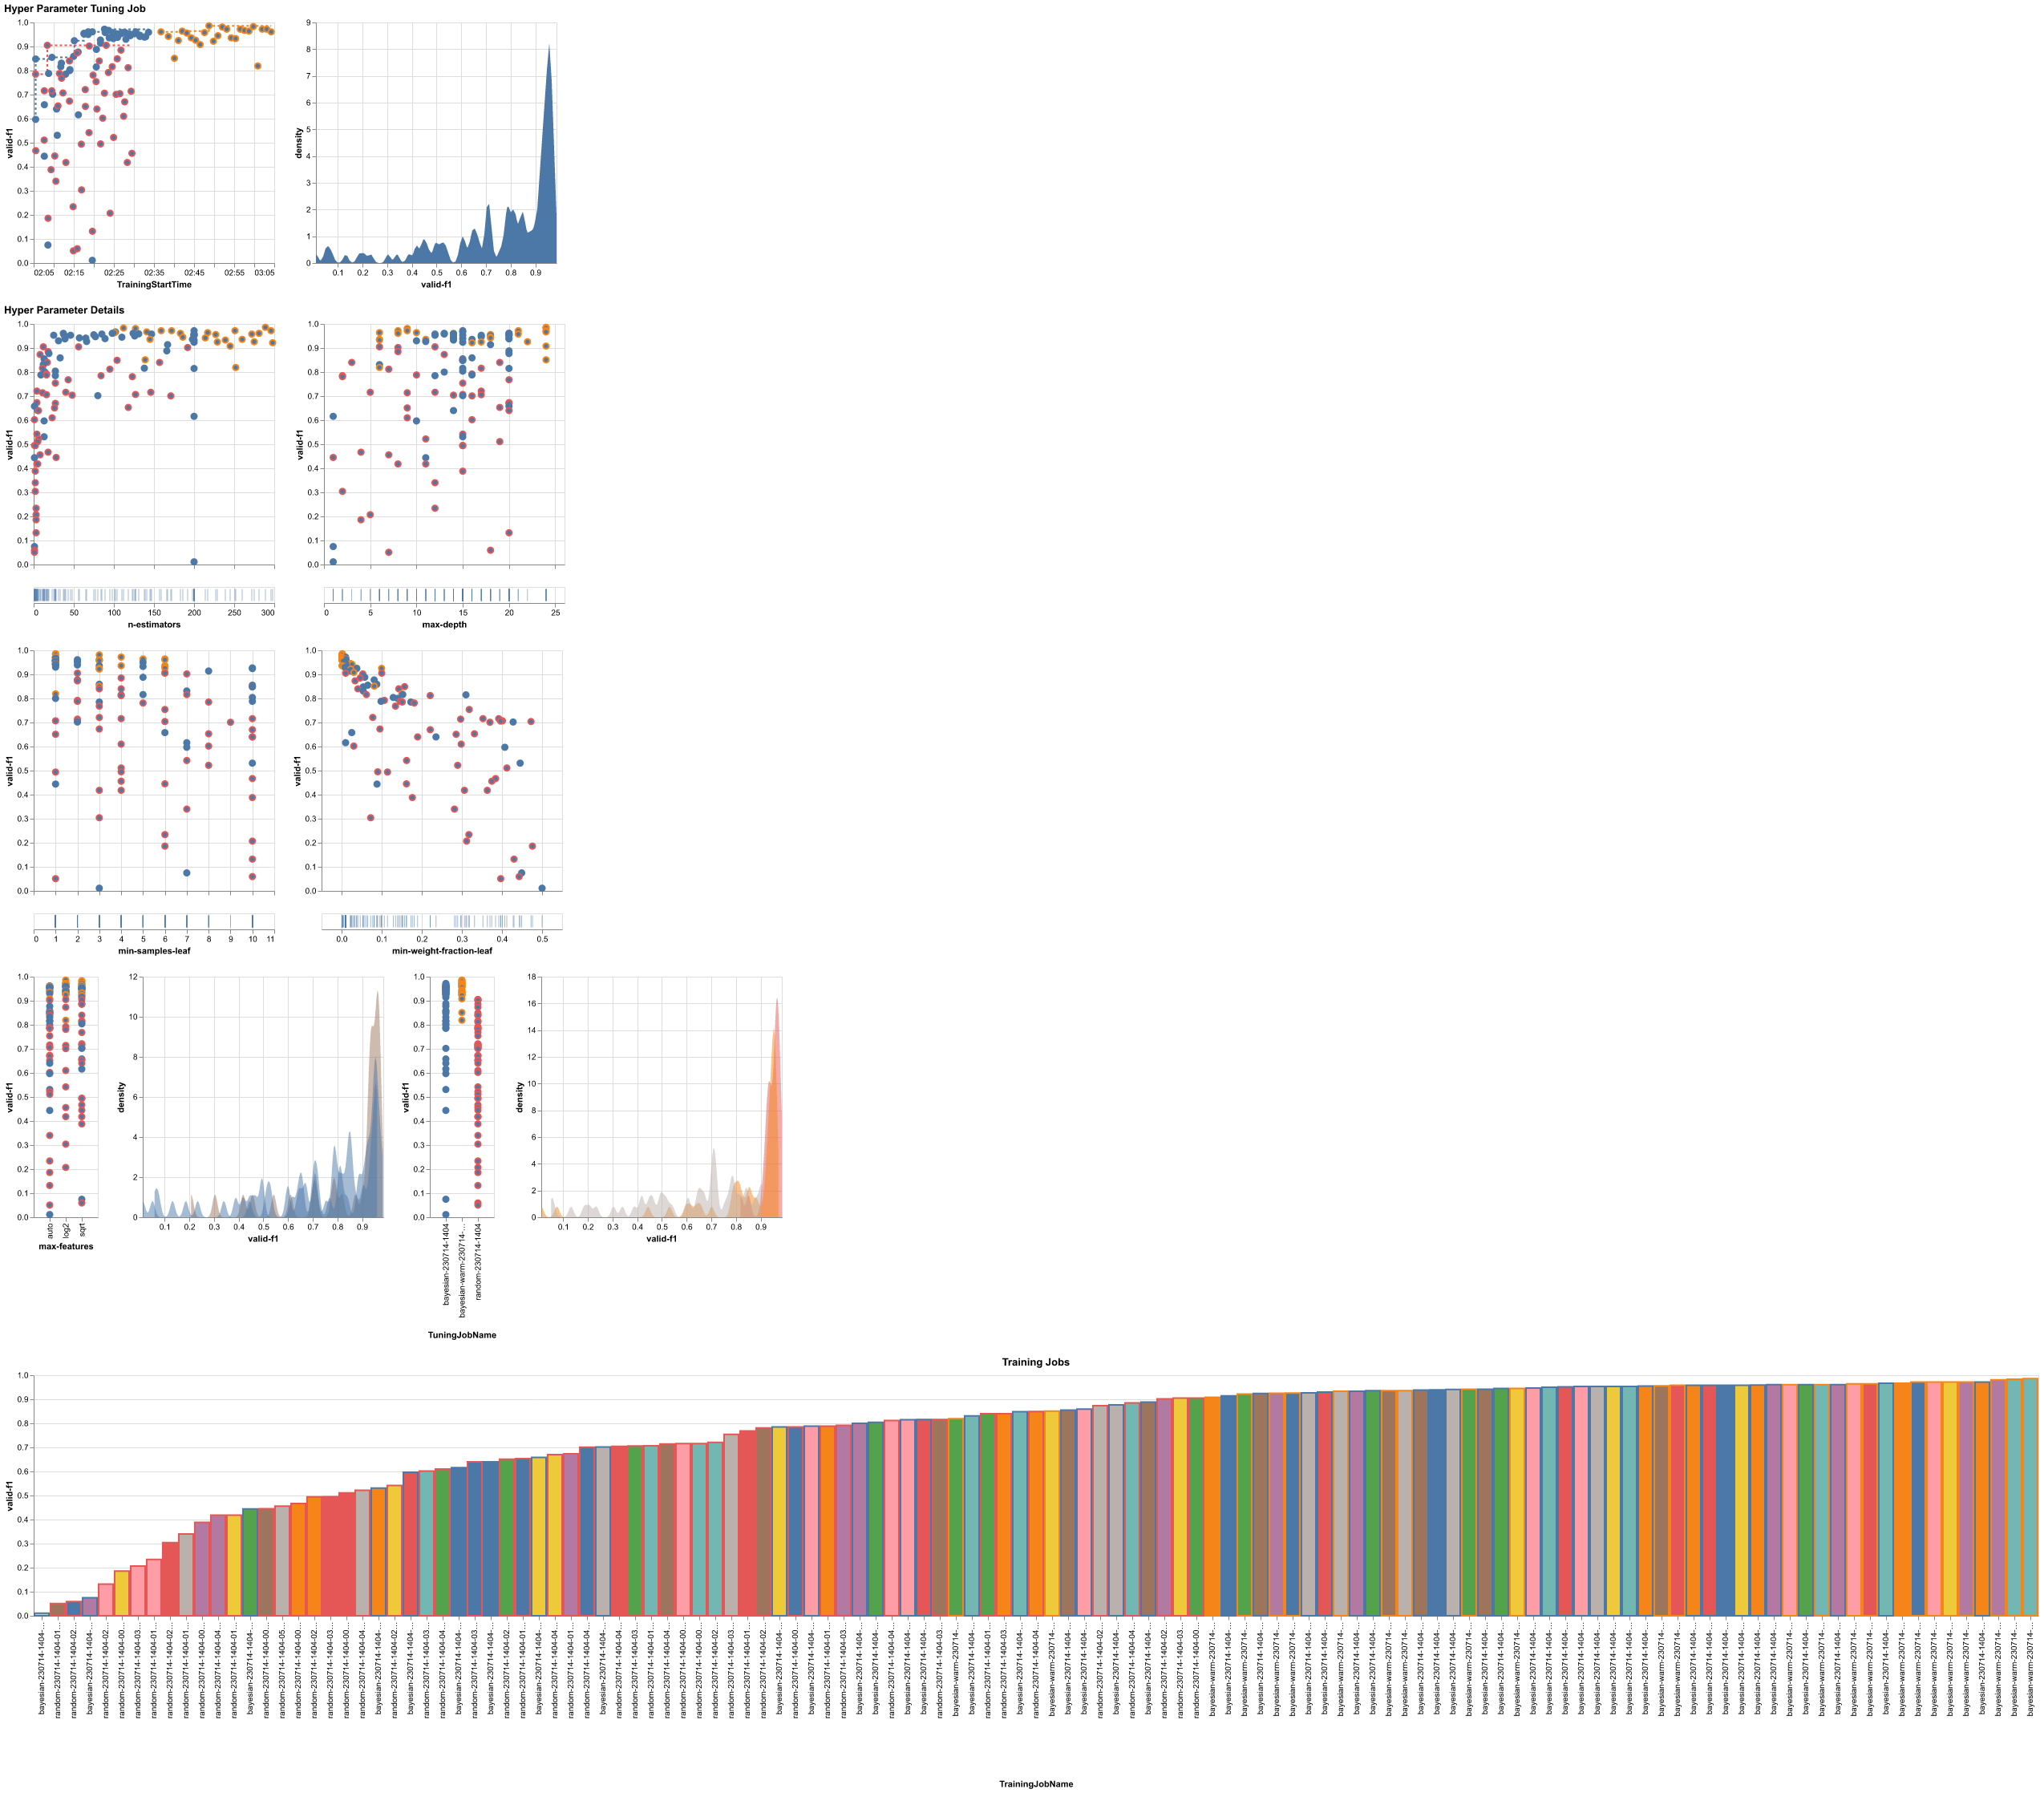

In [33]:
visualize_tuning_job(warmstarted_tuner, advanced=True, trials_only=True)

## Final Note

As it turns out, to use the existing knowledge in our heads (the understanding of hyperparameter value ranges) together with the captured knowledge in SageMaker Automatic Model Tuning (the previous trials that we now use using warmstart), we were able to continue to improve on the objective. And the overall result was much better. 

Also, recognize above how SageMaker AMT pre-dominantly probed areas that were previously unexplored. The data points with the orange outline belong to the second optimization run.

You have now completed this notebook on advanced tuning concepts.

## Cleanup 

To avoid incurring unwanted costs when you’re done experimenting with HPO, you must remove all files in your S3 bucket with the prefix `amt-visualize-demo` and also [shut down Studio resources](https://docs.aws.amazon.com/sagemaker/latest/dg/notebooks-run-and-manage-shut-down.html).

Uncomment and run the following code to remove all S3 files created by this notebook. Note that`{BUCKET}` is the variable with our bucket name that we defined earlier, you may also write your bucket name as plaintext here.

If you wish to keep the datasets or the model artifacts, you may modify the prefix in the code to `amt-visualize-demo/data` to only delete the data or `amt-visualize-demo/output` to only delete the model artifacts.

In [34]:
#!aws s3 rm s3://{BUCKET}/amt-visualize-demo --recursive